# Rainfall Data

This script extracts monthly rainfall data for both the CEH-GEAR and Met Office data sets

In [3]:
from convertbng.util import convert_lonlat
from shapely.geometry import shape, Point
from descartes import PolygonPatch
from netCDF4 import Dataset
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm
from itertools import product
import xarray as xr
import locations
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# Required if changes are made to private libraries.
import importlib
importlib.reload(locations)

<module 'locations' from 'C:\\Users\\Andy\\Desktop\\Video Prediction\\locations.py'>

In [5]:
file = "E:/31-12-2020/forecast-data/3-1998.grib"

In [6]:
ds = xr.open_dataset(file, engine='cfgrib')

In [7]:
ds.variables

Frozen({'number': <xarray.IndexVariable 'number' (number: 7)>
array([201, 202, 203, 204, 205, 206, 207])
Attributes:
    long_name:      ensemble member numerical id
    units:          1
    standard_name:  realization, 'time': <xarray.Variable ()>
array('1998-03-01T00:00:00.000000000', dtype='datetime64[ns]')
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time, 'step': <xarray.IndexVariable 'step' (step: 30)>
array([2678400000000000, 2764800000000000, 2851200000000000, 2937600000000000,
       3024000000000000, 3110400000000000, 3196800000000000, 3283200000000000,
       3369600000000000, 3456000000000000, 3542400000000000, 3628800000000000,
       3715200000000000, 3801600000000000, 3888000000000000, 3974400000000000,
       4060800000000000, 4147200000000000, 4233600000000000, 4320000000000000,
       4406400000000000, 4492800000000000, 4579200000000000, 4665600000000000,
       4752000000000000, 4838400000000000, 4924800000000000, 5

## 1. Region Points

To begin we define the regions and locations for which we agglomerate the rainfall.

In [3]:
regions = locations.get_shapefiles_ukcp()

In [4]:
def calculate_points(regions, output_file="./data/locations/{}.npy"):
    if not os.path.exists(output_file.format(list(regions)[0])):
        northing_range = np.arange(1250000, 0, -30000)
        easting_range = np.arange(0, 700000, 30000)
        for x, y in tqdm(product(easting_range, northing_range), total=easting_range.shape[0]*northing_range.shape[0]):
            for r in regions:
                if shape(regions[r]['polygon']).contains(Point(x, y)):
                    if 'points' not in regions[r]:
                        regions[r]['points'] = []
                    regions[r]['points'].append((x, y))
        for r in regions:
            np.save(output_file.format(r), regions[r]['points'])
    else:
        for r in regions:
            regions[r]['points'] = np.load(output_file.format(r))
calculate_points(regions)

Next let's take a look at the points defined to make sure they're reasonable.

In [5]:
def plot_regions(regions, axs=None):
    plt.rcParams['figure.figsize'] = [8, 10]
    if not axs:
        axs = plt.figure().gca()
    for idx, r in enumerate(regions):
        axs.add_patch(PolygonPatch(regions[r]['polygon'], fc='w', ec='k', alpha=1, zorder=0))
    axs.set_xlim([0, 700000])
    axs.set_ylim([0, 1250000])
    #axs.set_title("(a)", fontsize=18)

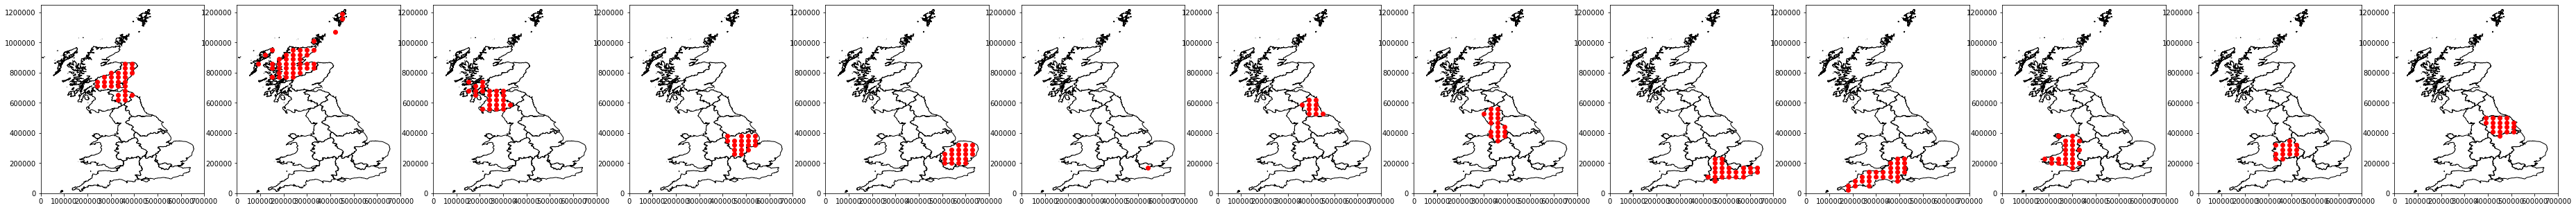

In [6]:
def plot_locations(regions):
    fig, axs = plt.subplots(nrows=1, ncols=len(regions), figsize=(len(regions)*5, 5))
    for ridx, r in enumerate(regions):
        plot_regions(regions, axs[ridx])
        for x, y in regions[r]['points']:
            axs[ridx].scatter(x, y, c='r')
plot_locations(regions)

## 2. Rainfall Extraction

Next, for each region the monthly rainfall totals.

Starting with the truth rainfall, to be loaded from CEH-GEAR data.

In [7]:
def extract_ceh_monthly_rainfall(years, regions, output_file="./data/rainfall/truth_rf.npy"):
    """ Calculates the average rainfall across each region in each month for the year range provided.
        Returns:
            A list of [month, year, region 1, ..., region 13]"""
    if not os.path.exists(output_file):
        region_rainfall = []
        for yidx, yr in tqdm(enumerate(years), total=len(years)):
            ds = Dataset("E:/Rainfall/Monthly/CEH_GEAR_monthly_GB_{}.nc".format(int(yr)))
            for midx, days in tqdm(enumerate(ds.variables['time'][:]), total=12):
                dte = date(1800, 1, 1) + timedelta(days=days)
                month_rainfall = [dte.month, dte.year]
                for ridx, r in enumerate(regions):
                    region_monthly_rf = 0
                    for x, y in regions[r]['points']:
                        eidx = np.abs(ds.variables['x'][:] - x).argmin()
                        nidx = np.abs(ds.variables['y'][:] - y).argmin()
                        if ds.variables['rainfall_amount'][midx, nidx, eidx]:
                            region_monthly_rf = region_monthly_rf + ds.variables['rainfall_amount'][midx, nidx, eidx]
                    month_rainfall.append(region_monthly_rf / len(regions[r]['points']))
                region_rainfall.append(month_rainfall)
            ds.close()
        np.save(output_file, np.array(region_rainfall))
    return np.load(output_file)
    
regional_rainfall = extract_ceh_monthly_rainfall(list(range(1993, 2018)), regions)

In [8]:
def extract_mo_monthly_rainfall(regions, output_file="./data/rainfall/mo_rf.npy",
                                meteo_folder="E:/31-12-2020/forecast-data/", leadtime=1):
    """ Calculates the average rainfall across each region in each month for the year range provided.
        Returns:
            A list of [month, year, region 1, ..., region 13]"""
    region_rainfall = []
    months = range(1, 13)
    years = range(1994, 2017)
    for y in tqdm(years):
        for m in tqdm(months):
            month_rainfall = [m, y]
            mdte = date(y, m, 1)
            forecast_date = mdte - relativedelta(months=leadtime)
            try:
                # Get forecast
                ds = xr.open_dataset(
                    meteo_folder + "{}-{}.grib".format(forecast_date.month, forecast_date.year), engine='cfgrib')
                rainfall = np.array(ds['tp'])
                if len(rainfall.shape) > 4:
                    print(meteo_folder + "{}-{}.grib".format(forecast_date.month, forecast_date.year))
                    rainfall = np.nanmean(rainfall[:, 0, :, :, :], axis=0)
                elif len(rainfall.shape) > 3:
                    rainfall = np.nanmean(rainfall, axis=0)
                lons, lats = np.array(ds['longitude']), np.array(ds['latitude'])
                ds.close()
                rainfall = (rainfall[-1, :, :] - rainfall[0, :, :])*1000
                # Extract rainfall for each region
                for ridx, r in enumerate(regions):
                    region_monthly_rf = 0
                    # Calculate average based on the points in the region
                    for xx, yy in regions[r]['points']:
                        try:
                            lon, lat = convert_lonlat([xx], [yy])
                            longidx = np.abs(lons - lon[0]).argmin()
                            latiidx = np.abs(lats - lat[0]).argmin()
                        except Exception as e:
                            print(e)
                            print(lon)
                            print(lat)
                        # Get the rainfall
                        rf = rainfall[latiidx, longidx]
                        region_monthly_rf = region_monthly_rf + rf
                    month_rainfall.append(region_monthly_rf / len(regions[r]['points']))
                region_rainfall.append(month_rainfall)
            except Exception as e:
                print("Failed to load for {}".format(mdte))
                print(e)
    np.save(output_file, np.array(region_rainfall))
    return np.array(region_rainfall)

region_rainfall = extract_mo_monthly_rainfall(regions)

E:/31-12-2020/forecast-data/6-1999.grib



Can't create file 'E:\\31-12-2020\\forecast-data\\1-2016.grib.90c91.idx'
Traceback (most recent call last):
  File "C:\Users\Andy\Anaconda3\envs\nn\lib\site-packages\cfgrib\messages.py", line 339, in from_indexpath_or_filestream
    self = cls.from_filestream(filestream, index_keys)
  File "C:\Users\Andy\Anaconda3\envs\nn\lib\site-packages\cfgrib\messages.py", line 293, in from_filestream
    for message in filestream:
  File "C:\Users\Andy\Anaconda3\envs\nn\lib\site-packages\cfgrib\messages.py", line 236, in __iter__
    with open(self.path, 'rb') as file:
FileNotFoundError: [Errno 2] No such file or directory: 'E:\\31-12-2020\\forecast-data\\1-2016.grib'
Can't read index file 'E:\\31-12-2020\\forecast-data\\1-2016.grib.90c91.idx'
Traceback (most recent call last):
  File "C:\Users\Andy\Anaconda3\envs\nn\lib\site-packages\cfgrib\messages.py", line 348, in from_indexpath_or_filestream
    index_mtime = os.path.getmtime(indexpath)
  File "C:\Users\Andy\Anaconda3\envs\nn\lib\genericpath.

Can't create file 'E:\\31-12-2020\\forecast-data\\8-2016.grib.90c91.idx'
Traceback (most recent call last):
  File "C:\Users\Andy\Anaconda3\envs\nn\lib\site-packages\cfgrib\messages.py", line 339, in from_indexpath_or_filestream
    self = cls.from_filestream(filestream, index_keys)
  File "C:\Users\Andy\Anaconda3\envs\nn\lib\site-packages\cfgrib\messages.py", line 293, in from_filestream
    for message in filestream:
  File "C:\Users\Andy\Anaconda3\envs\nn\lib\site-packages\cfgrib\messages.py", line 236, in __iter__
    with open(self.path, 'rb') as file:
FileNotFoundError: [Errno 2] No such file or directory: 'E:\\31-12-2020\\forecast-data\\8-2016.grib'
Can't read index file 'E:\\31-12-2020\\forecast-data\\8-2016.grib.90c91.idx'
Traceback (most recent call last):
  File "C:\Users\Andy\Anaconda3\envs\nn\lib\site-packages\cfgrib\messages.py", line 348, in from_indexpath_or_filestream
    index_mtime = os.path.getmtime(indexpath)
  File "C:\Users\Andy\Anaconda3\envs\nn\lib\genericpath.

Failed to load for 2016-02-01
[Errno 2] No such file or directory: 'E:\\31-12-2020\\forecast-data\\1-2016.grib'
Failed to load for 2016-03-01
[Errno 2] No such file or directory: 'E:\\31-12-2020\\forecast-data\\2-2016.grib'
Failed to load for 2016-04-01
[Errno 2] No such file or directory: 'E:\\31-12-2020\\forecast-data\\3-2016.grib'
Failed to load for 2016-05-01
[Errno 2] No such file or directory: 'E:\\31-12-2020\\forecast-data\\4-2016.grib'
Failed to load for 2016-06-01
[Errno 2] No such file or directory: 'E:\\31-12-2020\\forecast-data\\5-2016.grib'
Failed to load for 2016-07-01
[Errno 2] No such file or directory: 'E:\\31-12-2020\\forecast-data\\6-2016.grib'
Failed to load for 2016-08-01
[Errno 2] No such file or directory: 'E:\\31-12-2020\\forecast-data\\7-2016.grib'
Failed to load for 2016-09-01
[Errno 2] No such file or directory: 'E:\\31-12-2020\\forecast-data\\8-2016.grib'
Failed to load for 2016-10-01
[Errno 2] No such file or directory: 'E:\\31-12-2020\\forecast-data\\9-201

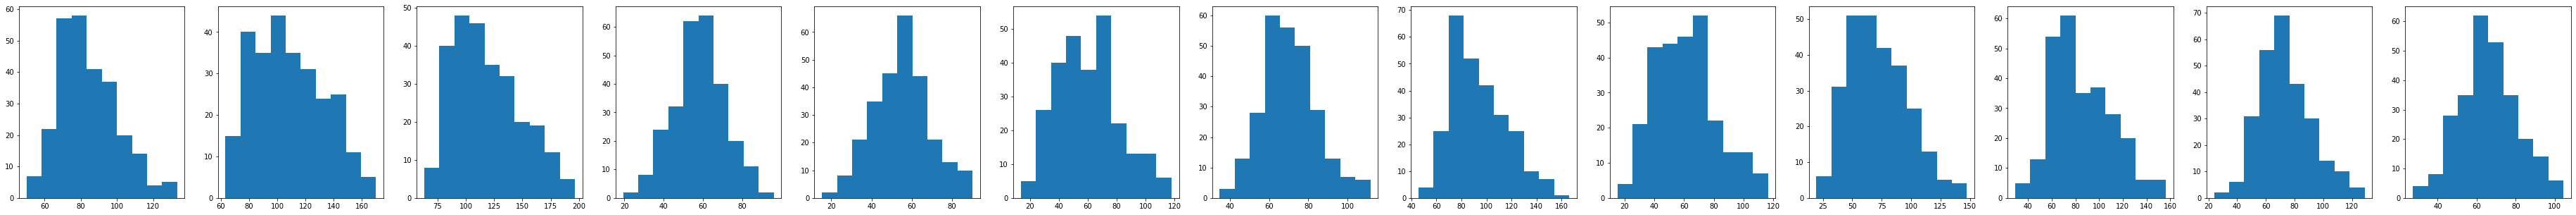

In [9]:
plt.rcParams['figure.figsize'] = [65, 5]
fig, axs = plt.subplots(nrows=1, ncols=13)

for n in range(0, 13):
    axs[n].hist(region_rainfall[:, n+2])